# LSTM - Time Series Dataset

- 서울시 기후 데이터 : 2011년 1월 1일 ~ 2019년 12월 31일
- https://data.kma.go.kr/cmmn/main/do
- 기후통계분석 -> 기온분석 -> 기간(20110101 ~ 20191231) -> 검색 -> CSV 다운로드
- Seoul_Temp.csv

# Impot Packages

- Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

# 1. Colab File Upload


> ## 1) 'Seoul_temp.csv' 파일을 Colab에 업로드 후 진행

In [3]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [4]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


# Data Preprocessing

> ## 1) 일일 평균온도('avg') 변화 시각화

- 일일 평균온도 변화에 일정한 패턴 확인

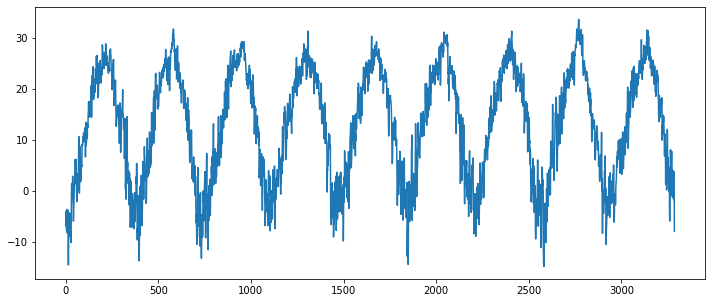

In [5]:
temp_data = temp[['avg']]
plt.figure(figsize = (12, 5))
plt.plot(temp_data)
plt.show()

> ## 2) Normalization

- tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [6]:
scaler = MinMaxScaler(feature_range = (-1, 1))
temp_data = scaler.fit_transform(temp_data)

> ## 3) Train vs. Test Split

- Train_Dataset : 2011년 1월 1일 ~ 2017년 12월 31일
- Test_Dataset : 2018년 1월 1일 ~ 2019년 12월 31일

In [7]:
train = temp_data[0 : 2557]
test = temp_data[2557 :]

In [22]:
train

array([[-0.67010309],
       [-0.61237113],
       [-0.57525773],
       ...,
       [-0.30309278],
       [-0.33195876],
       [-0.40206186]])

# 3. 시계열 데이터 처리 함수

> ## 1) 시계열 학습용 데이터 생성 함수 정의

- X : 학습 평균온도 데이터
- y : 정답 평균온도 데이터
- 일정 기간의 X로 y를 예측하도록 학습

In [8]:
def create_dataset(time_data, look_back = 1):
    data_X, data_y = [], []

    for i in range(len(time_data) - look_back):
        data_X.append(time_data[i:(i + look_back), 0])   # i ~ look_back 날까지를 X
        data_y.append(time_data[i + look_back, 0])       # X 마지막 날의 다음날을 y

    return np.array(data_X), np.array(data_y)

> ## 2) look_back 기간 설정 후 학습데이터 생성

- 180일 기간 평균온도로 다음날 평균온도 예측 데이터 생성

In [10]:
look_back = 180 

train_X, train_y = create_dataset(train, look_back)    # train을 X, y로 나눈다.  
test_X, test_y = create_dataset(test, look_back)       # test을 X, y로 나눈다. 

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

In [24]:
train_y

array([ 0.59175258,  0.64536082,  0.62886598, ..., -0.30309278,
       -0.33195876, -0.40206186])

> ## 3) Tensor Reshape

In [11]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

# 4. LSTM Modeling

> ## 1) Model Define

In [12]:
model = Sequential()
model.add(LSTM(64,
               input_shape = (None, 1)))
model.add(Dense(1, activation = 'tanh'))

- model summary

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

In [14]:
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam')

> ## 3) Model Fit

- 약 5분

In [15]:
%%time

hist = model.fit(train_X, train_y,
                 epochs = 200,
                 batch_size = 16,
                 validation_data = (test_X, test_y))

Epoch 1/200
149/149 [==============================] - 33s 13ms/step - loss: 0.0536 - val_loss: 0.0153
Epoch 2/200
149/149 [==============================] - 1s 9ms/step - loss: 0.0169 - val_loss: 0.0137
Epoch 3/200
149/149 [==============================] - 1s 9ms/step - loss: 0.0145 - val_loss: 0.0126
Epoch 4/200
149/149 [==============================] - 1s 10ms/step - loss: 0.0149 - val_loss: 0.0112
Epoch 5/200
149/149 [==============================] - 1s 9ms/step - loss: 0.0141 - val_loss: 0.0106
Epoch 6/200
149/149 [==============================] - 1s 10ms/step - loss: 0.0114 - val_loss: 0.0091
Epoch 7/200
149/149 [==============================] - 1s 10ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 8/200
149/149 [==============================] - 1s 10ms/step - loss: 0.0103 - val_loss: 0.0079
Epoch 9/200
149/149 [==============================] - 1s 10ms/step - loss: 0.0081 - val_loss: 0.0099
Epoch 10/200
149/149 [==============================] - 1s 10ms/step - loss: 0.0092 

> ## 4) 학습결과 시각화

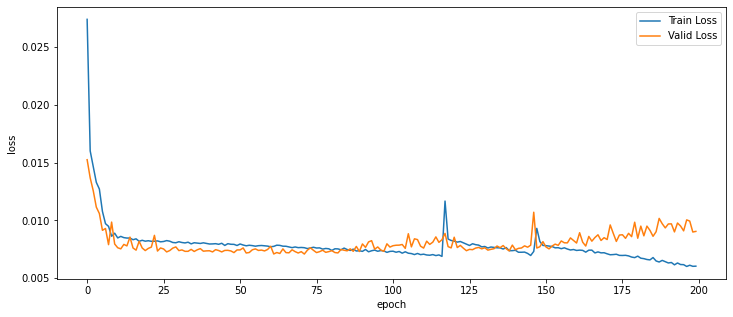

In [17]:
plt.figure(figsize = (12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc = 'upper right')
plt.show()
# 150회가 넘어가면서 overfitting 경향이 있다

> ## 5) Model Evaluate

In [18]:
trainScore = model.evaluate(train_X, train_y, verbose = 0)
print('Train Score : ', trainScore)

testScore = model.evaluate(test_X, test_y, verbose = 0)
print('Test Score : ', testScore)

Train Score :  0.0058790529146790504
Test Score :  0.00905489269644022


# 5. Model Predict

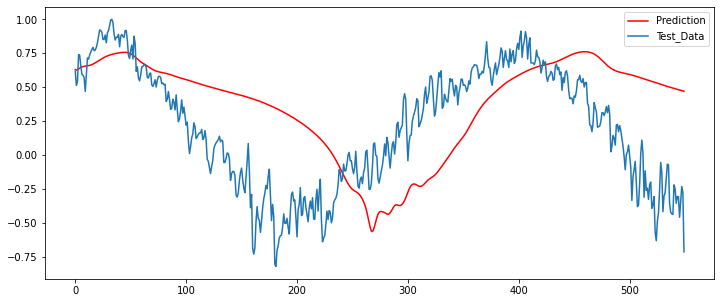

In [21]:
look_ahead = 550

xhat = test_X[0]  # 550행
predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size = 1)  # X_test 데이터로 예측
    predictions[i] = prediction                                   # look_ahead 만큼 예측
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize = (12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label = 'Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label = 'Test_Data')  # test_y 데이터
plt.legend()
plt.show()


###
#The End
###